In [58]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

train_data1 = pd.read_csv('./BATADAL_dataset03.csv', sep = ',')
train_data2 = pd.read_csv('./BATADAL_dataset04.csv', sep = ', ')
test_data = pd.read_csv('./BATADAL_test_dataset.csv', sep = ',')

print("Shape non-attack: ", train_data1.shape)
print("Shape train: ", train_data2.shape)
print("Shape test: ", test_data.shape)

# All numeric values except from the first (datetime)
# print(train_data1.columns.values)

# convert DATETIME to timestamp
train_data = pd.concat([train_data1, train_data2], axis=0, ignore_index=True)
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'], infer_datetime_format=True)
train_data['Year'] = train_data['DATETIME'].apply(lambda x: x.year)
train_data['Month'] = train_data['DATETIME'].apply(lambda x: x.month)
train_data['Day'] = train_data['DATETIME'].apply(lambda x: x.day)
train_data['Hour'] = train_data['DATETIME'].apply(lambda x: x.hour)

test_data['DATETIME'] = pd.to_datetime(test_data['DATETIME'], infer_datetime_format=True)
test_data['Year'] = test_data['DATETIME'].apply(lambda x: x.year)
test_data['Month'] = test_data['DATETIME'].apply(lambda x: x.month)
test_data['Day'] = test_data['DATETIME'].apply(lambda x: x.day)
test_data['Hour'] = test_data['DATETIME'].apply(lambda x: x.hour)

# Final versions of training and test dataframes
y = train_data['ATT_FLAG'].values
train_data = train_data.drop(columns=['DATETIME', 'ATT_FLAG'])
test_data = test_data.drop(columns=['DATETIME'])

# Training and test dataset
X = train_data.values
X_test = test_data.values

# drop columns with 0 variance as they can be of no use
index = np.std(X, axis=0) != 0
X = X[:, index]

# separate the two training datasets again
X1 = X[:8761]
X2 = X[8761:]
y1 = y[:8761]
y2 = y[8761:]

# NaNs
print("Number of NaN values in training dataset: ", np.sum(pd.isna(train_data).values))
print("Number of NaN values in test dataset: ", np.sum(pd.isna(train_data).values))


print("Training dataset shape: ", X.shape)
print("Number of attacks: ", np.sum(y==1))

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Shape non-attack:  (8761, 45)
Shape train:  (4177, 45)
Shape test:  (2089, 44)
Number of NaN values in training dataset:  0
Number of NaN values in test dataset:  0
Training dataset shape:  (12938, 40)
Number of attacks:  219


## Correlation matrix

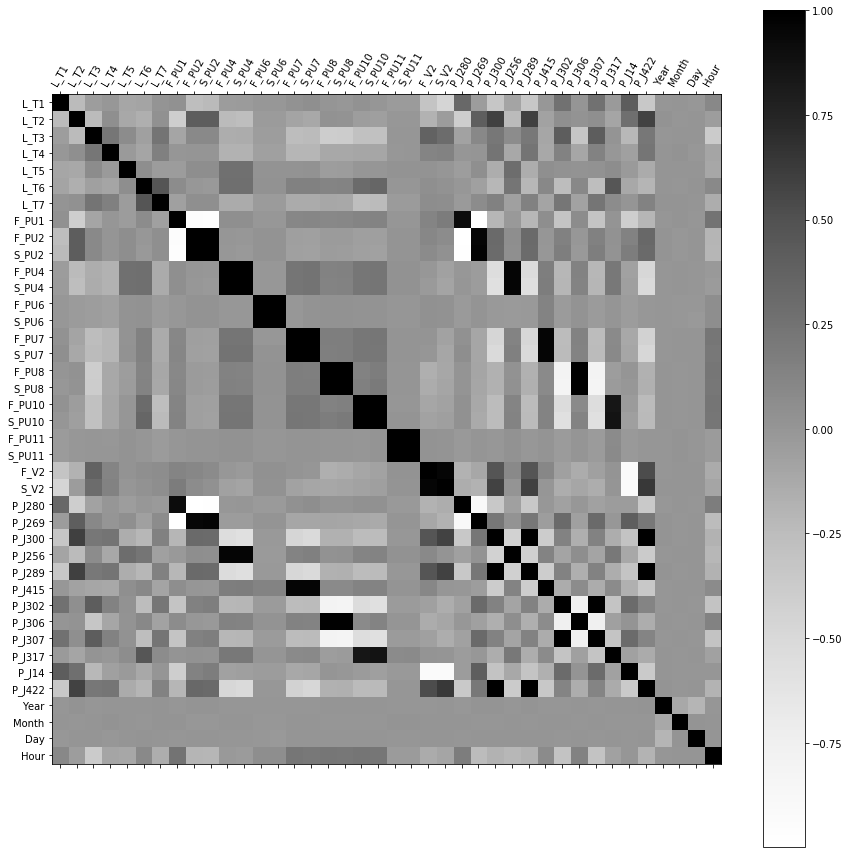

In [97]:
# Extract columns names corresponding to features with non-zero variance
labels = train_data.columns[index]

plt.figure(figsize = (15,15))
corr_matrix = np.corrcoef(X_1, rowvar=False)
plt.matshow(corr_matrix, fignum=1, cmap='Greys')
plt.xticks(range(len(labels)), labels, rotation=60)
plt.yticks(range(len(labels)), labels)
plt.colorbar()

In [106]:
# find the least correlated sensors with T1
sort_ind = np.argsort(np.abs(corr_matrix[0,:]))
print(corr_matrix[0,sort_ind])
print(labels[sort_ind])

[-0.0025181  -0.00255945  0.00289886  0.00393931  0.00683222 -0.00848909
 -0.00868052 -0.00913863 -0.01034483  0.01047714 -0.01355998 -0.01476825
  0.02385498  0.02433093 -0.02788634 -0.03168852 -0.03323761 -0.03339735
  0.0380163   0.03955635 -0.04003576 -0.04528875 -0.05106025 -0.08730679
 -0.08829333  0.09737008 -0.10682489 -0.23116315 -0.24185582 -0.25926733
  0.26039329  0.26213173 -0.31592442  0.33094823 -0.3331569  -0.33678464
 -0.35565592  0.40990079 -0.46273609  1.        ]
Index(['Year', 'S_PU10', 'P_J306', 'Month', 'F_PU8', 'F_PU6', 'S_PU6', 'S_PU8',
       'Day', 'L_T7', 'L_T4', 'P_J415', 'F_PU10', 'F_PU7', 'P_J317', 'S_PU4',
       'F_PU11', 'S_PU11', 'F_PU1', 'S_PU7', 'P_J269', 'F_PU4', 'L_T3',
       'P_J256', 'L_T6', 'Hour', 'L_T5', 'S_PU2', 'L_T2', 'F_PU2', 'P_J307',
       'P_J302', 'F_V2', 'P_J280', 'P_J300', 'P_J289', 'P_J422', 'P_J14',
       'S_V2', 'L_T1'],
      dtype='object')


In [113]:
from sklearn.feature_selection import SelectKBest

target = X1[:,0]
reg = X1[:, 1:]

feat_select = SelectKBest(k=10)
feat_select.fit(reg, target)
selected_ind = feat_select.get_support()
print(labels[1:][selected_ind])

Index(['S_PU2', 'F_PU6', 'S_PU6', 'S_PU7', 'S_PU10', 'F_PU11', 'S_PU11',
       'F_V2', 'S_V2', 'Year'],
      dtype='object')


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


### Visualize data, trying to reveal trend and seasonal components
Obviously there is no trend

Text(0.5, 0, 'Day')

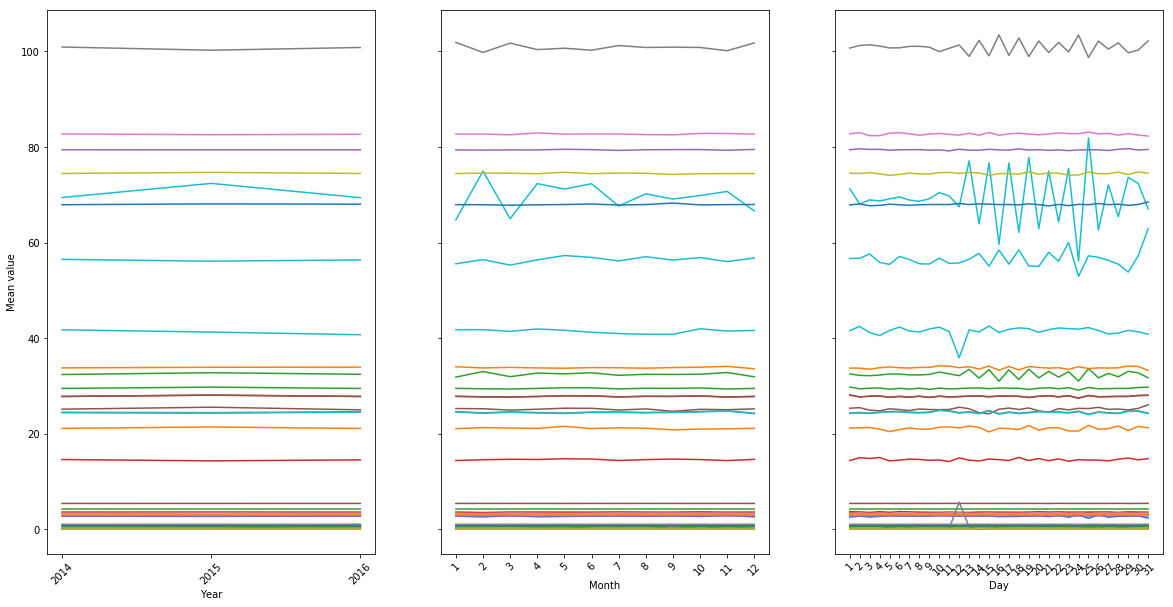

In [70]:
mean_yearly = train_data.drop(['ATT_FLAG', 'Month', 'Day', 'Hour'], axis=1).groupby('Year').mean()
mean_monthly = train_data.drop(['ATT_FLAG', 'Year','Day', 'Hour'], axis=1).groupby(['Month']).mean()
mean_daily = train_data.drop(['ATT_FLAG', 'Month', 'Year', 'Hour'], axis=1).groupby('Day').mean()

labels_yearly = mean_yearly.index.values
labels_monthly = mean_monthly.index.values
labels_daily = mean_daily.index.values

f, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 10), sharey=True)

ax[0].plot(mean_yearly.values)
ax[0].set_xticks(range(len(labels_yearly)))
ax[0].set_xticklabels(labels_yearly, rotation=45)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Mean value")

ax[1].plot(mean_monthly.values)
ax[1].set_xticks(range(len(labels_monthly)))
ax[1].set_xticklabels(labels_monthly, rotation=45)
ax[1].set_xlabel("Month")

ax[2].plot(mean_daily.values)
ax[2].set_xticks(range(len(labels_daily)))
ax[2].set_xticklabels(labels_daily, rotation=45)
ax[2].set_xlabel("Day")

Text(0.5, 0, 'Day')

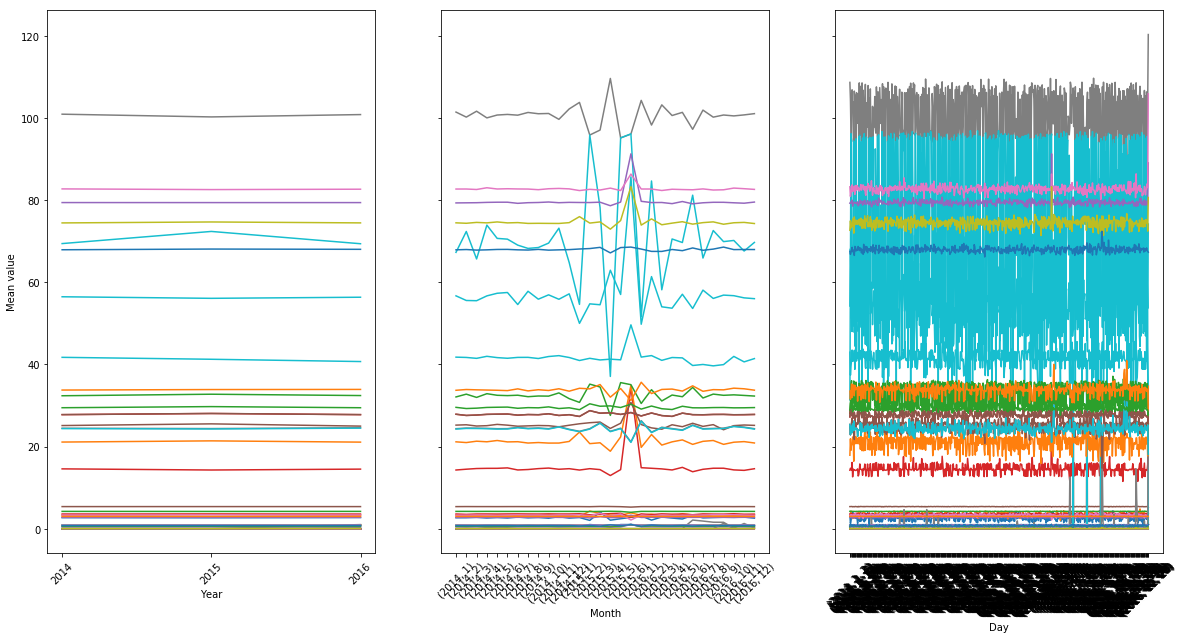

In [73]:
mean_yearly = train_data.drop(['ATT_FLAG', 'Month', 'Day', 'Hour'], axis=1).groupby('Year').mean()
mean_monthly = train_data.drop(['ATT_FLAG', 'Day', 'Hour'], axis=1).groupby(['Year', 'Month']).mean()
mean_daily = train_data.drop(['ATT_FLAG', 'Hour'], axis=1).groupby(['Year','Month','Day']).mean()

labels_yearly = mean_yearly.index.values
labels_monthly = mean_monthly.index.values
labels_daily = mean_daily.index.values

f, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 10), sharey=True)

ax[0].plot(mean_yearly.values)
ax[0].set_xticks(range(len(labels_yearly)))
ax[0].set_xticklabels(labels_yearly, rotation=45)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Mean value")

ax[1].plot(mean_monthly.values)
ax[1].set_xticks(range(len(labels_monthly)))
ax[1].set_xticklabels(labels_monthly, rotation=45)
ax[1].set_xlabel("Month")

ax[2].plot(mean_daily.values)
ax[2].set_xticks(range(len(labels_daily)))
ax[2].set_xticklabels(labels_daily, rotation=45)
ax[2].set_xlabel("Day")


### ARMA

Autocorrelation and partial-autocorrelation plots

(8761, 40)


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


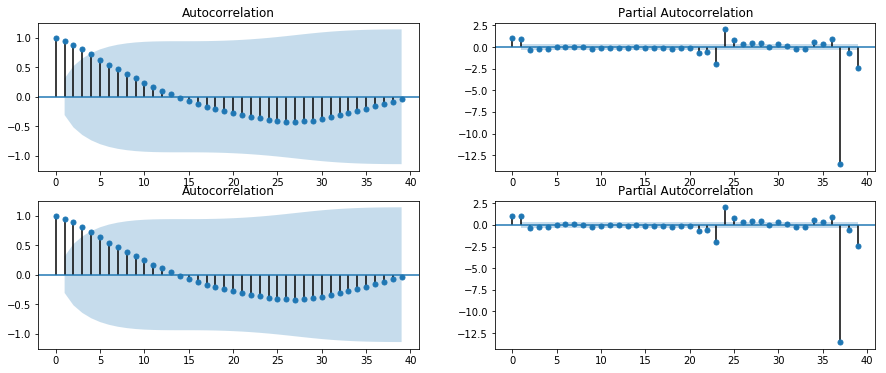

In [60]:
scaler = StandardScaler()
scaler.fit(X1)
X1_scaled = scaler.transform(X1)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,6))
fig = sm.graphics.tsa.plot_acf(X1[:40, 0], ax=ax[0,0])
fig = sm.graphics.tsa.plot_pacf(X1[:40, 0], ax=ax[0,1])
fig = sm.graphics.tsa.plot_acf(X1_scaled[:40, 0], ax=ax[1,0])
fig = sm.graphics.tsa.plot_pacf(X1_scaled[:40, 0], ax=ax[1,1])

In [95]:
from pmdarima import auto_arima

tt = auto_arima(y = X1[:,0], exogenous=X1[:,1:], seasonal = False, start_p=1, start_q=1, return_valid_fits=True)
tt

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/pmdarima/arima/auto.py:229: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: 

KeyboardInterrupt: 

In [76]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(endog=X1[:, 0], order=[3,0,2]).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("HQIC: ", model.hqic)

print("DW test: ", sm.stats.durbin_watson(model.resid))

AIC:  -13412.405014924629
BIC:  -13362.858557595964
HQIC:  -13395.522959513133
DW test:  1.9572787394390152


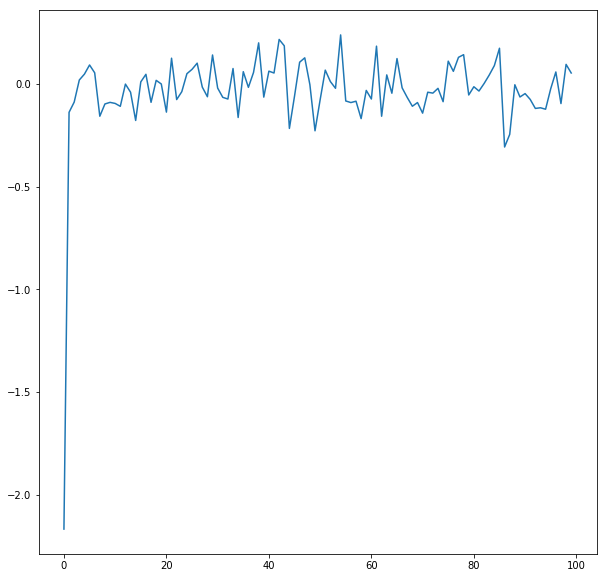

In [75]:
plt.figure(figsize=(10,10))
plt.plot(model.resid[:100])

In [78]:
from sklearn.linear_model import LinearRegression


reg = LinearRegression(n_jobs=-1).fit(X1[:,1:], X1[:,0])
predictions = reg.predict(X1[:,1:])

True versus predicted value for L_T1

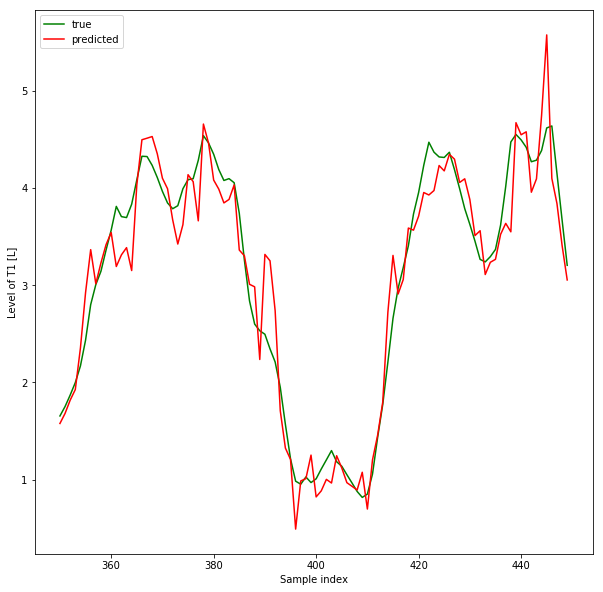

Average error:  -2.5085327060897833e-11
Max error:  1.6685838372692001


In [147]:
offset = 350
num_points = 100

ind = np.arange(offset, offset+num_points)

plt.figure(figsize=(10,10))
plt.plot(ind, X1[offset:offset+num_points, 0], color='g', label='true')
plt.plot(ind, predictions[offset:offset+num_points], color='r', label='predicted')
plt.xlabel("Sample index")
plt.ylabel("Level of T1 [L]")
plt.legend()
plt.show()

print("Average error: ", np.mean(residuals))
print("Max error: ", np.max(residuals))

Text(0, 0.5, 'Error')

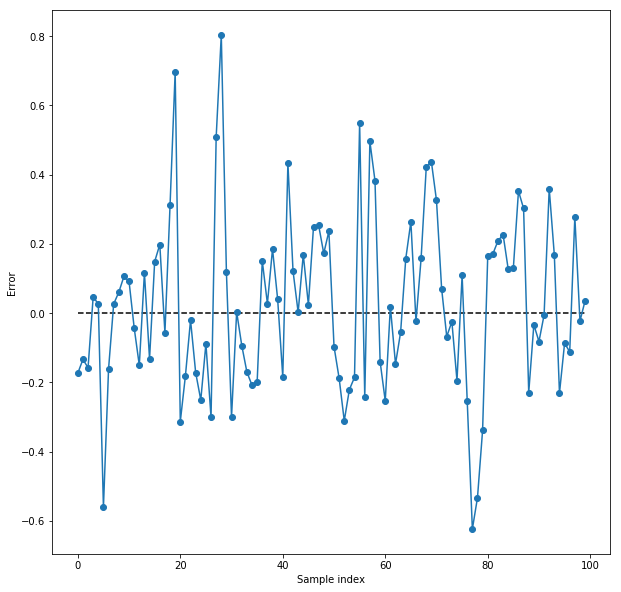

In [148]:
residuals = np.subtract(X1[:,0], predictions)
plt.figure(figsize=(10,10))
plt.plot(residuals[:100], marker='o')
plt.hlines(y=0, xmin=0, xmax = 99, linestyles='dashed', color='k')
plt.xlabel("Sample index")
plt.ylabel("Error")

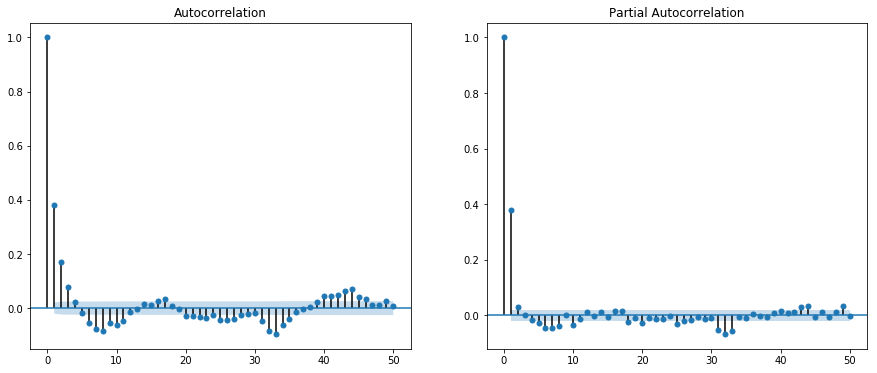

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig = sm.graphics.tsa.plot_acf(residuals, ax=ax[0], lags=50)
fig = sm.graphics.tsa.plot_pacf(residuals, ax=ax[1], lags=50)

In [94]:
print("DW test: ", sm.stats.durbin_watson(residuals))

DW test:  1.2395505614078046


In [96]:
tt = auto_arima(y = X1[:,0], exogenous=X1[:,1:], seasonal = False, start_p=1, max_p=15, start_q=1, max_q=15, return_valid_fits=True)
tt

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conv

[ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 2),
    out_of_sample_size=0, scoring='mse', scoring_args={},
    seasonal_order=None, solver='lbfgs', start_params=None,
    suppress_warnings=False, transparams=True, trend=None,
    with_intercept=True),
 ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
    out_of_sample_size=0, scoring='mse', scoring_args={},
    seasonal_order=None, solver='lbfgs', start_params=None,
    suppress_warnings=False, transparams=True, trend=None,
    with_intercept=True),
 ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 0, 1),
    out_of_sample_size=0, scoring='mse', scoring_args={},
    seasonal_order=None, solver='lbfgs', start_params=None,
    suppress_warnings=False, transparams=True, trend=None,
    with_intercept=True),
 ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 3),
    out_of_sample_size=0, scoring='mse', scoring_args={},
    seasonal_order=None, solver='lbfg

## Discrete Methods

In [190]:
states = np.unique(y)
enum = {
    -999:0,
    0:1,
    1:2
}

def compute_transition_matrix(targets, enum, smooth, normalize):    
    
    transition_matrix = np.zeros((len(enum), len(enum)), dtype=int)
    for i in range(len(targets)-1):
        if targets[i] != -999 and targets[i+1] != -999:
            transition_matrix[enum[targets[i]], enum[targets[i+1]]] = transition_matrix[enum[targets[i]], enum[targets[i+1]]] + 1
    if smooth and np.min(transition_matrix) == 0:
        transition_matrix = transition_matrix+1
    if normalize:
        transition_matrix = transition_matrix/np.sum(transition_matrix, axis=1)[...,np.newaxis]
    return transition_matrix

In [191]:
t = compute_transition_matrix(y, enum, False, False)
t

array([[   0,    0,    0],
       [   0, 8760,    0],
       [   0,    0,  214]])

(array([10492, 10493, 10494, 10495, 10496, 10497, 10498, 10499, 10500,
        10501, 10502, 10503, 10504, 10505, 10506, 10507, 10508, 10509,
        10510, 10511, 10512, 10513, 10514, 10515, 10516, 10517, 10518,
        10519, 10520, 10521, 10522, 10523, 10524, 10525, 10526, 10527,
        10528, 10529, 10530, 10531, 10532, 10533, 11098, 11099, 11100,
        11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109,
        11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118,
        11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127,
        11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136,
        11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145,
        11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11154,
        11155, 11156, 11157, 11612, 11613, 11614, 11615, 11616, 11617,
        11618, 11619, 11620, 11621, 11622, 11623, 11624, 11625, 11626,
        11627, 11628, 11629, 11630, 11631, 11632, 11633, 11634, 11635,
      